# Imports

In [26]:
## Logging and Shell
import logging
logging.basicConfig(
    level=logging.ERROR,
    force=True
)

## Numeric imports
import pandas as pd

## File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

DIM    = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Static Paths
RAW_DATA_DIR  = Path('raw_monomer_data')
PROC_DATA_DIR = Path('processed_monomer_data')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

In [27]:
from polymerist.monomers import specification

input_data_path = PROC_DATA_DIR / '20231114_polyid_data_density_FILTERED.csv'
df = pd.read_csv(input_data_path, index_col=0)

### Load pre-defined functional group SMARTS queries

In [28]:
with Path('poly_rxns/fn_group_smarts.json').open('r') as file:
    fn_group_smarts = json.load(file)

fn_groups = {
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

### Backmap reactions and their functional groups

In [29]:
from polymerist.rdutils.reactions import reactions

rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}

assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

In [30]:
rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_backmap.values()
}

rxn_groups = {
    rxnname : tuple(reactant.GetProp('_Name') for reactant in rxn.GetReactants())
        for rxnname, rxn in rxns.items()
}

In [31]:
whitelisted_rxns = ['amide', 'urethane', 'ester', 'carbonate']
df = df[df.mechanism.map(lambda s : s in whitelisted_rxns)]

### Group by mechanism

In [32]:
keys = ['mechanism']

df_grouper = df.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

# Polymerizing fragments

## Example for polymerization of individual molecule

polycarbonate_phosgene


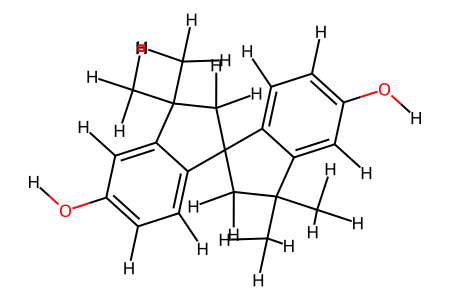

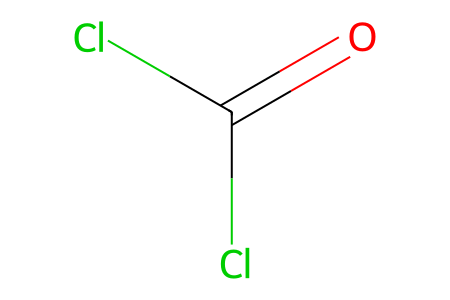

In [36]:
# frame = frames['ester']
# frame = frames['amide']
frame = frames['carbonate']
row = frame.loc[frame.index[14]]

mechname = rxn_backmap[row['mechanism']]
print(mechname)

rxn_pathway = rxns[mechname]
named_reactants = {}
for i in (1, 2):
    reactant = Chem.MolFromSmiles(row[f'smiles_expanded_monomer_{i}'], sanitize=False)
    Chem.SanitizeMol(reactant, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    display(reactant)
    named_reactants[ row[f'IUPAC_monomer_{i}'] ] = reactant

reactants = [i for i in named_reactants.values()]


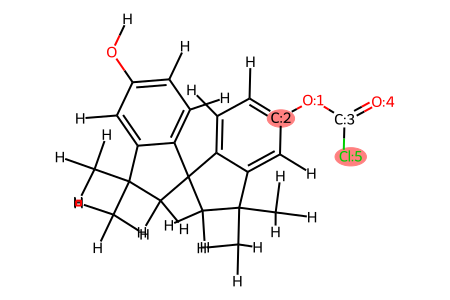

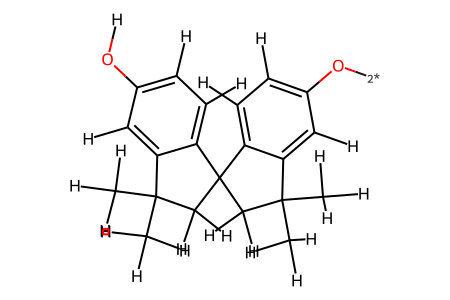

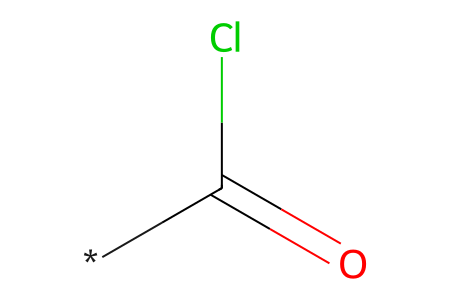

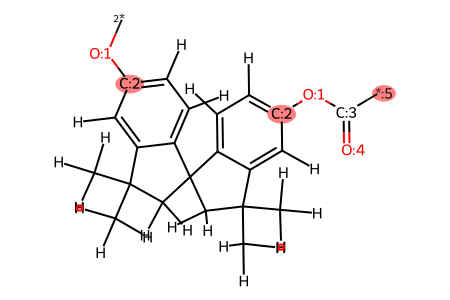

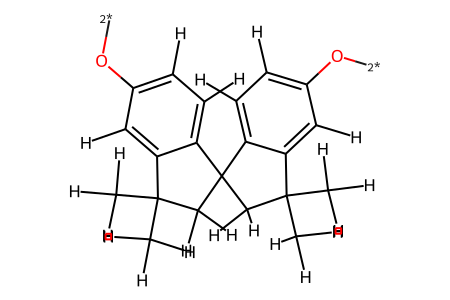

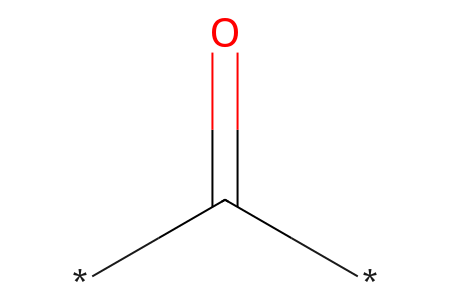

In [37]:
from polymerist.rdutils.amalgamation import portlib
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn_pathway)
for (dimer, pair) in reactor.propagate(reactants):
    display(dimer)
    for frag in pair:
        display(frag)

    print('='*50)

## Polymerize all SMILES into well-specified fragments with ports

In [38]:
from polymerist.monomers import MonomerGroup
from polymerist.monomers import specification


# mono_info_dir  : Path = Path('monomer_files')
mono_info_dir  : Path = Path('monomer_fragments')
mono_info_dir.mkdir(exist_ok=True)


for (i, row) in df.iterrows():
    # look up reactive groups and pathway by chemistry
    mechname = rxn_backmap[row['mechanism']]
    rxn_pathway = rxns[mechname]

    chem_dir : Path = mono_info_dir / mechname
    chem_dir.mkdir(exist_ok=True)

    # load reactants with IUPAC names from chemical table
    named_reactants = {}
    for j in (1, 2):
        reactant = Chem.MolFromSmiles(row[f'smiles_expanded_monomer_{j}'], sanitize=False)
        Chem.SanitizeMol(reactant, sanitizeOps=specification.SANITIZE_AS_KEKULE)
        named_reactants[ row[f'IUPAC_monomer_{j}'] ] = reactant

    initial_reactants = [reactants for reactants in named_reactants.values()] # must convert to list

    # first round of polymerization (initiation)
    monogrp = MonomerGroup()
    reactor = reactors.PolymerizationReactor(rxn_pathway)
    for dimer, frags in reactor.propagate(initial_reactants):
        for assoc_group_name, rdfragment in zip(named_reactants.keys(), frags):
            # generate spec-compliant SMARTS
            raw_smiles = Chem.MolToSmiles(rdfragment)
            exp_smiles = specification.expanded_SMILES(raw_smiles)
            spec_smarts = specification.compliant_mol_SMARTS(exp_smiles)

            # record to monomer group
            affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
            monogrp.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]

    monogrp.to_file(chem_dir / f'{mechname}_{i}.json')